# Johan Hedenström
Exploration

In [2]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import matplotlib.pyplot as plt

from utils.preprocess import load_tof
from utils.plot import make_palette
from image_processing import process
from scipy.optimize import curve_fit
from utils.trajectory import fit, fx, find_domain, compute_confidence_band

In [6]:
FILE_PATH = '../data/tof_erda/raw/I_36MeV_SH2-1_TiN-ref.lst' # I_36MeV_SH2-3_SiC-ref.lst, I_36MeV_SH2-1_TiN-ref.lst
X, y = load_tof(FILE_PATH)
X_filtered, y_filtered = process(X, y)

Fitting cluster 1
Fitting cluster 2
Fitting cluster 3


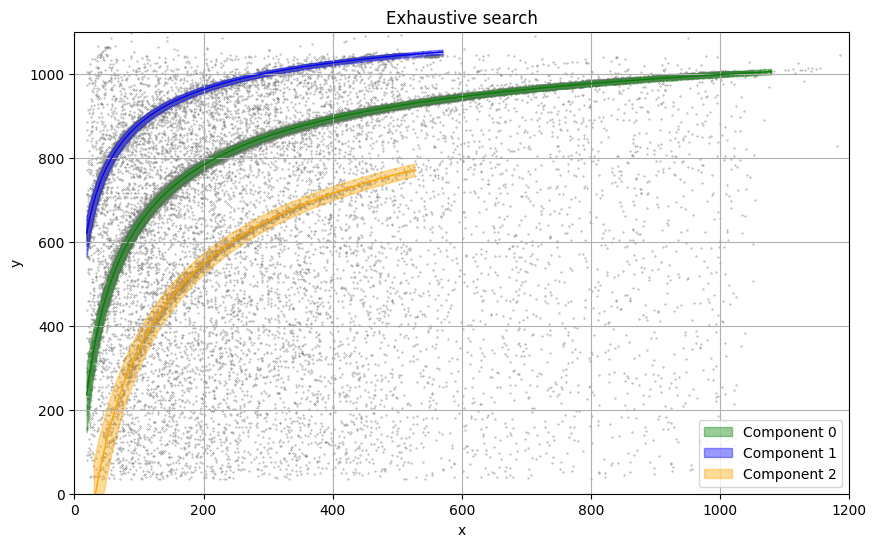

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Trajectory model
def trajectory_formula(x, a, b, c):
    return a / np.sqrt(x + b) + c

# Approximate distance (point-to-trajectory)
def perpendicular_distance(x, y, a, b, c):
    predicted_y = trajectory_formula(x, a, b, c)
    slope = -a / (2 * (x + b)**(3/2))
    perp_dist = np.abs(y - predicted_y) / np.sqrt(1 + slope**2)
    return perp_dist

# Vectorized density evaluation
def evaluate_density_vectorized(x, y, params, threshold):
    a, b, c = params
    if np.min(x + b) <= 0:
        return -1
    predicted_y = a / np.sqrt(x + b) + c
    slope = -a / (2 * (x + b)**(3/2))
    perp_dist = np.abs(y - predicted_y) / np.sqrt(1 + slope**2)
    density = np.sum(perp_dist < threshold)
    return density

# Brute force, with fine-tuning
def coarse_to_fine_fit(x, y, a_range, b_range, c_range, threshold, coarse_factor=10, refinement_steps=3):
    best_params = None
    max_density = -1

    for step in range(refinement_steps):
        # Param grid
        a_vals = np.linspace(a_range[0], a_range[1], coarse_factor)
        b_vals = np.linspace(b_range[0], b_range[1], coarse_factor)
        c_vals = np.linspace(c_range[0], c_range[1], coarse_factor)
        
        densities = []
        params_list = []
        
        # Compute densities for each combination
        for a in a_vals:
            for b in b_vals:
                if np.min(x + b) <= 0:
                    continue
                for c in c_vals:
                    params = (a, b, c)
                    density = evaluate_density_vectorized(x, y, params, threshold)
                    densities.append(density)
                    params_list.append(params)
        
        # Find combination that maximizes density
        densities = np.array(densities)
        best_idx = np.argmax(densities)
        if densities[best_idx] > max_density:
            max_density = densities[best_idx]
            best_params = params_list[best_idx]

        # Define new search range around best params
        if best_params is not None:
            a_best, b_best, c_best = best_params
            a_range = (max(a_range[0], a_best - (a_range[1] - a_range[0]) / coarse_factor),
                       min(a_range[1], a_best + (a_range[1] - a_range[0]) / coarse_factor))
            b_range = (max(b_range[0], b_best - (b_range[1] - b_range[0]) / coarse_factor),
                       min(b_range[1], b_best + (b_range[1] - b_range[0]) / coarse_factor))
            c_range = (max(c_range[0], c_best - (c_range[1] - c_range[0]) / coarse_factor),
                       min(c_range[1], c_best + (c_range[1] - c_range[0]) / coarse_factor))
    
    return best_params

# Non-linear regression fit to cluster points
def fit_trajectory_to_cluster(x, y, in_cluster):
    x_cluster = x[in_cluster]
    y_cluster = y[in_cluster]

    popt, pcov = curve_fit(trajectory_formula, x_cluster, y_cluster, p0=(-5000, 10, 1200))
    return popt, pcov

# Find a set amount of clusters and fit trajectory lines
def fit_multiple_clusters_with_trajectory(x, y, num_clusters, a_range, b_range, c_range, threshold):
    clusters = []
    remaining_x, remaining_y = x.copy(), y.copy()

    for i in range(num_clusters):
        print(f"Fitting cluster {i + 1}")
        # Find approximate trajectory line
        coarse_params = coarse_to_fine_fit(remaining_x, remaining_y, a_range, b_range, c_range, threshold)
        
        # Cluster points based on proximity
        perp_distances = perpendicular_distance(remaining_x, remaining_y, *coarse_params)
        in_cluster = perp_distances < threshold
        
        # Fit new line to identified cluster points
        trajectory_params, _ = fit_trajectory_to_cluster(remaining_x, remaining_y, in_cluster)        
        clusters.append({
            "trajectory_params": trajectory_params,
            "x": remaining_x[in_cluster],
            "y": remaining_y[in_cluster]
        })
        
        # Exclude cluster points from dataset (for next iteration)
        remaining_x = remaining_x[~in_cluster]
        remaining_y = remaining_y[~in_cluster]

    return clusters

# Parameter ranges
a_range = (-10000, 0)
b_range = (-500, 500)
c_range = (500, 2000)
threshold = 20  # Perpendicular distance threshold
number_of_clusters = 3

# Find clusters
clusters = fit_multiple_clusters_with_trajectory(X_filtered, y_filtered, num_clusters=number_of_clusters, a_range=a_range, b_range=b_range, c_range=c_range, threshold=threshold)

# Plot
plt.figure(figsize=(10, 6))
colors = ['green', 'blue', 'orange', 'pink', 'red', 'yellow']
plt.scatter(X, y, s=0.1, color='gray')
for i, cluster in enumerate(clusters):   
    x_curve = np.linspace(min(cluster["x"]), max(cluster["x"]), 500)
    a, b, c = cluster["trajectory_params"]
    y_curve = trajectory_formula(x_curve, a, b, c)
    plt.plot(x_curve, y_curve, color=colors[i], linewidth=1)

    # Compute and plot band
    params = (a, b, c)
    band_params = compute_confidence_band(cluster["x"], cluster["y"], params, 0.95)
    y_lower = trajectory_formula(x_curve, *(band_params[0]))
    y_upper = trajectory_formula(x_curve, *(band_params[1]))
    plt.fill_between(x_curve, y_lower, y_upper, color=colors[i], alpha=0.4, label=f"Component {i}")

plt.xlabel('x')
plt.ylabel('y')
plt.ylim([0, 1100])
plt.xlim([0, 1200])
plt.legend()
plt.title('Exhaustive search')
plt.grid(True)
plt.show()
